<h1>Deploy de um modelo de Machine Learning</h1>
<br>
Este exemplo de modelo em produção foi feito com base no vídeo de Meigarom, do canal Seja Um Data Scientist. <a href='https://www.youtube.com/watch?v=d6caxBhnf2I&ab_channel=SejaUmDataScientist'>Youtube</a>
<br>
<br>
O conjunto de dados possui informações de vinhos, como densidade, pH e com isso descobre-se a qualidade do mesmo.
<br>
<br>
É um modelo simples de Machine Learning com base em regressão para deploy em uma API feito por mim. O modelo de Machine Learning usa um método de regularização L1 e L2, o algoritmo chama-se ElasticNet. Será feito também uma reescala de dois atributos do DataFrame, para uma melhora da performance. 
<br>
<br>
Mas o foco principal deste projeto é o deploy do modelo, que só é possível com a criação do API feito num arquivo python com a biblioteca/framework Flask. Com ele, criamos um host, porém neste projeto foi feito no servidor local. Dentro da API, com nome de handler.py, são feitos requisições para a predição do modelo treinado para sabermos a qualidade do vinho. A requisição são <b>todos os atributos necessários</b> para sabermos a qualidade do vinho. Dentro do modelo em produção, são feitos tarefas para que todo o processo de preparação dos dados seja feito de forma automática, sem que o modelo precise parar sua produção. Foi criado um arquivo chamado wine_quality.py, que é usado como uma biblioteca dentro da API. Esta biblioteca possui um método que faz uma preparação dos dados e os retornam transformados. Estas são as tarefas no qual citei anteriormente.

<h1>Importação das bibliotecas</h1>

In [1]:
import requests
import pandas as pd
import numpy as np
import pickle
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

<h1>Carregamento dos dados</h1>

In [2]:
csv_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
df_raw = pd.read_csv( csv_url, sep=';' )

<h1>Preparação dos dados</h1>

In [3]:
df1 = df_raw.copy()

<h1>Reescalando os dados</h1>

In [4]:
# min max scaler
mms = MinMaxScaler()

In [5]:
# free sulfur dioxide
df1['free sulfur dioxide'] = mms.fit_transform(df1[['free sulfur dioxide']].values)
pickle.dump(mms, open('C:\\Users\\ja_me\\Projetos_Portfolio\\free_sulfur_scaler.pkl', 'wb'))

# total sulfur dioxide
df1['total sulfur dioxide'] = np.log1p(df1['total sulfur dioxide'])
df1['total sulfur dioxide'] = mms.fit_transform(df1[['total sulfur dioxide']].values)
pickle.dump(mms, open('C:\\Users\\ja_me\\Projetos_Portfolio\\total_sulfur_scaler.pkl', 'wb'))

<h1>Comentário</h1>
<br>
Foi feito um arquivo Pickle para cada escala de cada atributo do dataset, para que quando houver novos dados, estes dados sejam reescalados da mesma forma que o dataset original. Este arquivo Pickle possui as informações de forma binária, de forma que ele não sofre alterações no processo.
<br>
<br>
No atributo 'total sulfur dioxide' foi feito uma transformação em log antes de reescalar seus dados, para que ele tenha uma distribuição quase normal. Isso é feito, pois os algoritmos funcionam melhor com dados com distribuição normal ou perto da normal. O gráfico de distribuição abaixo mostra a transformação feita neste atributo.

In [6]:
mms.data_min_

array([1.94591015])

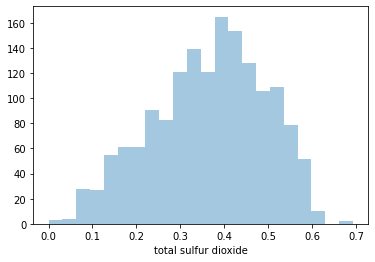

In [7]:
sns.distplot(np.log1p(df1['total sulfur dioxide']), kde=False)

In [8]:
train, test = train_test_split( df1 ) #75% e 25% test

# train and test dataset
x_train = train.drop( 'quality', axis=1 )
y_train = train['quality']

x_test = test.drop( 'quality', axis=1 )
y_test = test['quality']

<h1>Modelo de Machine Learning</h1>

In [9]:
# model definition
model = ElasticNet( alpha=0.5, l1_ratio=0.5, random_state=42 )

# training
model.fit( x_train, y_train )

# prediction
pred = model.predict( x_test )

rmse = np.sqrt( mean_squared_error( y_test, pred ))
mae = mean_absolute_error( y_test, pred )
r2  = r2_score( y_test, pred )


print( 'RMSE: {}'.format( rmse ) )
print( 'MAE: {}'.format( mae ) )
print( 'R2: {}'.format( r2 ))


# save trained model
pickle.dump( model, open( 'C:\\Users\\ja_me\\Projetos_Portfolio\\model_wine_quality.pkl', 'wb' ) )

RMSE: 0.7359413506484034
MAE: 0.6165797588374666
R2: 0.12498942349174635


<h1>Comentário</h1>
<br>
O modelo não possui um bom valor, com um r2 score de 0,12. Como o foco do projeto não é conseguir um modelo muito bom, passarei adiante.

<h1>Predição</h1>

In [10]:
df = df_raw.drop('quality', axis=1).sample()

In [11]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
1027,6.4,0.795,0.0,2.2,0.065,28.0,52.0,0.99378,3.49,0.52,11.6


In [12]:
df_json = df.to_json(orient='records')

In [13]:
df_json

'[{"fixed acidity":6.4,"volatile acidity":0.795,"citric acid":0.0,"residual sugar":2.2,"chlorides":0.065,"free sulfur dioxide":28.0,"total sulfur dioxide":52.0,"density":0.99378,"pH":3.49,"sulphates":0.52,"alcohol":11.6}]'

In [14]:
# url = 'http://192.168.0.112:5000/predict'
url = 'https://model-wine-quality.herokuapp.com/predict'
data = df_json
header = {'Content-type': 'application/json'}
# Request
r = requests.post(url=url, data=data, headers=header)
print(r.status_code)

200


In [15]:
pd.DataFrame(r.json(), columns=r.json()[0].keys())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,prediction
0,6.4,0.795,0.0,2.2,0.065,40.395461,75.020142,0.99378,3.49,0.52,11.6,5.782095


<h1>Comentário</h1>
<br>
Nesta parte é feito a predição do modelo em produção, com todos os atributos passados para o modelo em forma de requisição. Nesta parte, é necessário transformar os dados em JSON, que é a forma que a API consegue "lê-los".

## Class In Production

In [16]:
import pickle
class WineQuality(object):
    def __init__(self):
        self.free_sulfur_scaler = pickle.load(open('C:\\Users\\ja_me\\Projetos_Portfolio\\free_sulfur_scaler.pkl', 'rb'))
        self.total_sulfur_scaler = pickle.load(open('C:\\Users\\ja_me\\Projetos_Portfolio\\total_sulfur_scaler.pkl', 'rb'))
        
    
    def data_preparation(self, df):
        # reescaling free sulfur
        df['free sulfur dioxide'] = self.free_sulfur_scaler.transform(df['free sulfur dioxide'])
        
        # reescaling total sulfur
        df['total sulfur dioxide'] = self.total_sulfur_scaler.transform(df['total sulfur dioxide'])
        
        return df

<h1>Comentário</h1>
<br>
Este é a classe criada, que virou o arquivo(biblioteca) para preparação dos dados dentro da API, de forma automática.

<h1>Conclusão</h1>
<br>
O modelo posteriormente foi feito o deploy na nuvem, na plataforma Heroku.